In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import numpy as np

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

In [3]:
class GNB:
    def __init__(self):
        self.priors = {}
        self.means = {}
        self.variances = {}
        self.classes = []
    
    def fit(self, X, y):
        # Convert to numpy arrays if they're pandas objects
        if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
            X = X.values
        if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
            y = y.values
            
        self.classes = np.unique(y)
        n_samples = X.shape[0]
        
        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = X_c.shape[0] / n_samples
            self.means[c] = np.mean(X_c, axis=0)
            self.variances[c] = np.var(X_c, axis=0)
    
    def gaussian_pdf(self, x, mean, var, epsilon=1e-9):
        # Convert to numpy arrays if they're pandas objects
        if isinstance(x, pd.Series):
            x = x.values
        if isinstance(mean, pd.Series):
            mean = mean.values
        if isinstance(var, pd.Series):
            var = var.values
            
        return (1 / np.sqrt(2 * np.pi * (var + epsilon))) * np.exp(-((x - mean) ** 2) / (2 * (var + epsilon)))
    
    def predict_proba(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        
        # Initialize array of zeros (n_samples, n_classes)
        probs = np.zeros((X.shape[0], len(self.classes)))
    
        for i, x in enumerate(X):
            posteriors = {}
            for j, c in enumerate(self.classes):
                prior = np.log(self.priors[c])
                likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.variances[c])))
                posteriors[c] = prior + likelihood
        
            # Softmax and store in pre-allocated array
            exp_probs = np.exp(list(posteriors.values()))
            probs[i] = exp_probs / np.sum(exp_probs)
    
        return probs  # Shape: (n_samples, n_classes)
    
    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

NB - Unbalanced Dataset

In [4]:
# Load dataset
df = pd.read_csv("../Datasets/Unbalanced_Binary.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,1
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,1
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,1
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,1
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,1


In [5]:
# Check class distribution
print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
1    437
0     80
Name: count, dtype: int64


In [6]:
# Splitting features and target
X = df.drop(columns=['target'])
y = df['target']

In [7]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes
print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (413, 29)
Test set shape: (104, 29)



Accuracy: 94.231%

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.92      0.80        13
           1       0.99      0.95      0.97        91

    accuracy                           0.94       104
   macro avg       0.85      0.93      0.88       104
weighted avg       0.95      0.94      0.95       104


Confusion Matrix:


C:\Users\rajit\AppData\Local\Temp\ipykernel_9788\2549305743.py:46: RuntimeWarning: divide by zero encountered in log
  likelihood = np.sum(np.log(self.gaussian_pdf(x, self.means[c], self.variances[c])))


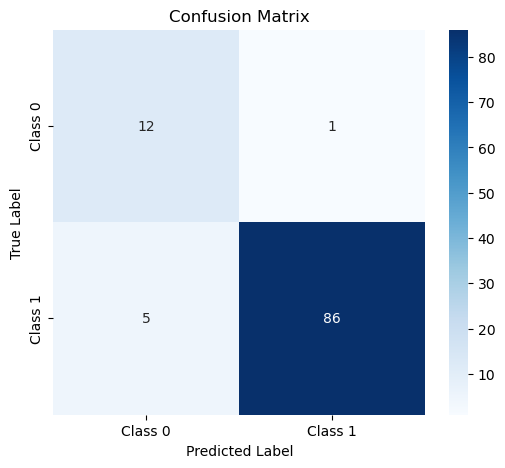

In [8]:
# Create and train Gaussian Naive Bayes classifier
gnb = GNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)
y_probs = gnb.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.3f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
#print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Class-wise Metrics:

Class 0:
Sensitivity: 0.9231
Specificity: 0.9451

Class 1:
Sensitivity: 0.9451
Specificity: 0.9231

Overall Metrics:
Sensitivity: 0.9451
Specificity: 0.9231


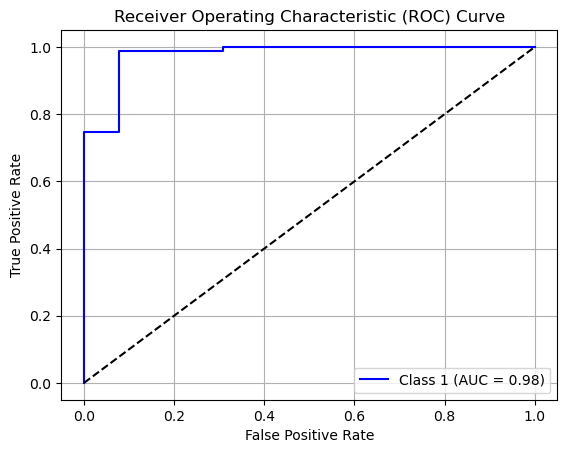

In [9]:
# Calculate sensitivity and specificity for each class
def class_sensitivity_specificity(cm, classes):
    metrics = {}
    for i, class_label in enumerate(classes):
        TP = cm[i,i]
        FN = sum(cm[i,:]) - TP
        FP = sum(cm[:,i]) - TP
        TN = cm.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        
        metrics[class_label] = {
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    return metrics

# Calculate metrics for each class
class_metrics = class_sensitivity_specificity(cm, np.unique(y))

# Print metrics for each class
print("\nClass-wise Metrics:")
for class_label, metrics in class_metrics.items():
    print(f"\nClass {class_label}:")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

# Calculate overall sensitivity and specificity
TN, FP, FN, TP = cm.ravel()
overall_sensitivity = TP / (TP + FN)
overall_specificity = TN / (TN + FP)
print("\nOverall Metrics:")
print(f"Sensitivity: {overall_sensitivity:.4f}")
print(f"Specificity: {overall_specificity:.4f}")

# ROC Curve
def plot_roc_curve_single(y_test, y_scores, positive_class):
    # Convert y_test into binary: 1 for positive_class, 0 otherwise
    y_test_bin = (y_test == positive_class).astype(int)
    
    # Compute ROC curve and AUC for the positive class
    fpr, tpr, _ = roc_curve(y_test_bin, y_scores[:, 1])  # Assuming y_scores[:, 1] corresponds to positive_class
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'Class {positive_class} (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the positive class (e.g., "Not Healthy" = 1)
plot_roc_curve_single(y_test, y_probs, positive_class=1)

NB - Balanced Dataset

In [10]:
# Load dataset
df = pd.read_csv("../Datasets/Balanced_Binary.csv")
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,1.942833,1.793557,-6.121474,-1.031132,0.487107,-0.346116,0.242493,-0.255091,-1.933793,0.456129,...,0.021294,-0.876791,-2.804382,-0.772752,0.902250,-0.283821,1.158110,-0.703144,-1.142507,1
1,-0.498266,4.290355,0.924083,-1.281493,8.153378,-2.302476,0.615296,-3.871441,1.491185,3.666561,...,-0.030226,1.076776,-1.426662,0.743057,0.212868,1.043947,0.948273,0.706128,-0.491125,1
2,-1.027512,3.363755,1.828574,-0.495802,7.458820,-2.484852,0.378415,-2.248700,-1.301424,4.136351,...,0.472101,1.206932,-0.923404,0.566657,0.293071,-0.145078,1.759649,0.516351,0.492429,1
3,2.736756,-2.241731,0.404660,-0.167861,-0.125442,0.496706,1.664382,-1.271026,0.213782,0.962099,...,-1.376614,-0.559114,-0.335620,0.088591,0.080121,-0.085828,0.038390,-0.096909,-0.426436,1
4,0.685796,0.223385,-2.080131,-0.011414,4.090118,0.650177,2.411078,2.637664,-1.594057,0.283371,...,0.540901,0.354731,-0.933172,-0.888606,0.902017,0.506791,0.640292,0.129010,0.092228,1


In [11]:
print("\nClass distribution:")
print(df['target'].value_counts())


Class distribution:
target
1    437
0    437
Name: count, dtype: int64


In [12]:
# Splitting features and target
X = df.drop(columns=['target'])
y = df['target']

In [13]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (699, 29)
Test set shape: (175, 29)


In [14]:
"""
Scaling is not needed as it is a probability based model
"""

'\nScaling is not needed as it is a probability based model\n'


Accuracy: 93.143%

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        90
           1       0.92      0.94      0.93        85

    accuracy                           0.93       175
   macro avg       0.93      0.93      0.93       175
weighted avg       0.93      0.93      0.93       175


Confusion Matrix:
[[83  7]
 [ 5 80]]


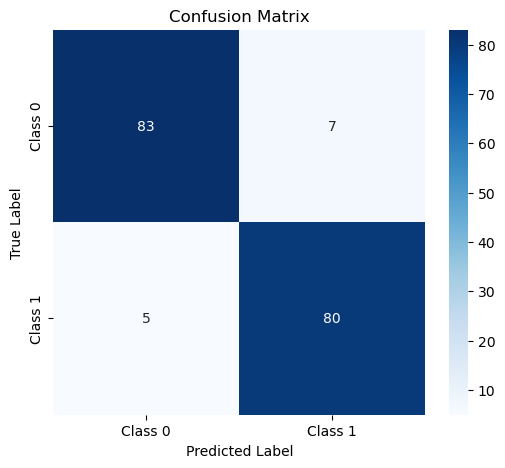

In [15]:
# Create and train Gaussian Naive Bayes classifier
gnb = GNB()
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)
y_probs = gnb.predict_proba(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy*100:.3f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Class 0", "Class 1"], 
            yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


Class-wise Metrics:

Class 0:
Sensitivity: 0.9222
Specificity: 0.9412

Class 1:
Sensitivity: 0.9412
Specificity: 0.9222

Overall Metrics:
Sensitivity: 0.9412
Specificity: 0.9222


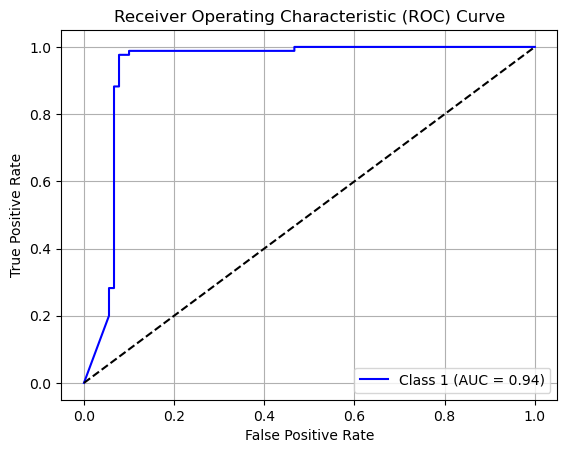

In [16]:
# Calculate sensitivity and specificity for each class
def class_sensitivity_specificity(cm, classes):
    metrics = {}
    for i, class_label in enumerate(classes):
        TP = cm[i,i]
        FN = sum(cm[i,:]) - TP
        FP = sum(cm[:,i]) - TP
        TN = cm.sum() - (TP + FP + FN)
        
        sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
        
        metrics[class_label] = {
            'sensitivity': sensitivity,
            'specificity': specificity
        }
    return metrics

# Calculate metrics for each class
class_metrics = class_sensitivity_specificity(cm, np.unique(y))

# Print metrics for each class
print("\nClass-wise Metrics:")
for class_label, metrics in class_metrics.items():
    print(f"\nClass {class_label}:")
    print(f"Sensitivity: {metrics['sensitivity']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")

# Calculate overall sensitivity and specificity
TN, FP, FN, TP = cm.ravel()
overall_sensitivity = TP / (TP + FN)
overall_specificity = TN / (TN + FP)
print("\nOverall Metrics:")
print(f"Sensitivity: {overall_sensitivity:.4f}")
print(f"Specificity: {overall_specificity:.4f}")


def plot_roc_curve_single(y_test, y_scores, positive_class):
    # Convert y_test into binary: 1 for positive_class, 0 otherwise
    y_test_bin = (y_test == positive_class).astype(int)
    
    # Compute ROC curve and AUC for the positive class
    fpr, tpr, _ = roc_curve(y_test_bin, y_scores[:, 1])  # Assuming y_scores[:, 1] corresponds to positive_class
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f'Class {positive_class} (AUC = {roc_auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random classifier)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_roc_curve_single(y_test, y_probs, positive_class=1)